In [ ]:
from uuid import UUID
from vitalx.types import VitalEnvironmentT
from vitalx.types import VitalRegionT

environment: VitalEnvironmentT = "sandbox"
region: VitalRegionT = "us"

team_id = UUID("TEAM_ID")
user_id = UUID("USER_ID")

In [56]:
from vitalx.aggregation.executor import Executor

query_executor = Executor(
    environment=environment,
    region=region,
    team_id=team_id,
)


## Aggregation Query

In [78]:
from datetime import date
from vitalx.aggregation import *

(sleep_score_by_day, sleep_score_by_month_and_weekday,) = query_executor.query(
    RelativeTimeframe(
        type="relative",
        anchor=date.today(),
        past=Period(value=6, unit="month"),
    ),

    select(
        group_key("*"),
        Sleep.score().newest(),
    ).group_by(date_trunc(Sleep.index(), 1, "day")),

    select(
        group_key("*"),
        Sleep.col("efficiency").mean(),
        Sleep.score().mean(),
    ).group_by(
        date_part(Sleep.index(), "month"),
        date_part(Sleep.index(), "weekday")
    ),

    user_id=user_id,
    config=QueryConfig(week_starts_on="monday"),
)


## Sleep Scores

In [70]:
sleep_score_by_day

group_key.0,newest.efficiency,newest.sleep_score
datetime[μs],f64,i64
2024-06-16 00:00:00,83.0,76
2024-06-17 00:00:00,82.0,72
2024-06-18 00:00:00,65.0,57
2024-06-19 00:00:00,83.0,75
2024-06-20 00:00:00,84.0,80
…,…,…
2024-12-09 00:00:00,92.93722,71
2024-12-10 00:00:00,96.93166,74
2024-12-11 00:00:00,97.793264,71


In [73]:
sleep_score_by_month_and_weekday

group_key.0,group_key.1,mean.efficiency,mean.sleep_score
i8,i8,f64,f64
6,1,85.5,75.5
6,2,75.5,63.0
6,3,82.0,71.5
6,4,80.0,71.0
6,5,84.0,71.0
…,…,…,…
12,3,98.134243,74.5
12,4,97.760092,69.5
12,5,98.939431,78.5


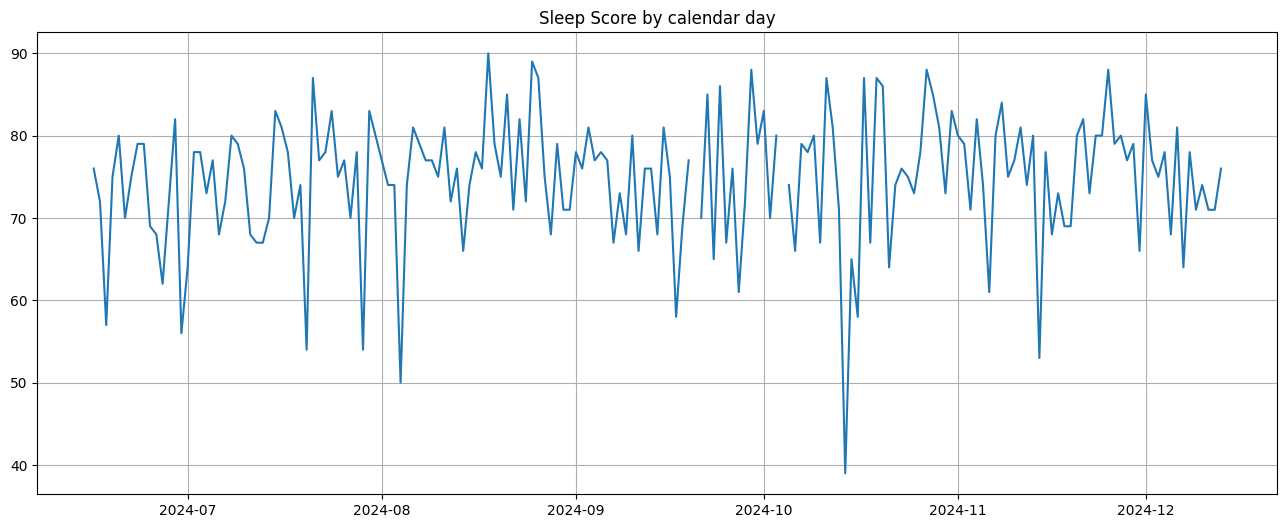

In [61]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16,6))
ax = plt.gca()
plt.title("Sleep Score by calendar day")
plt.grid()
plt.plot(
    sleep_score_by_day.get_column("group_key.0"),
    sleep_score_by_day.get_column("newest.sleep_score"),
)
plt.show()

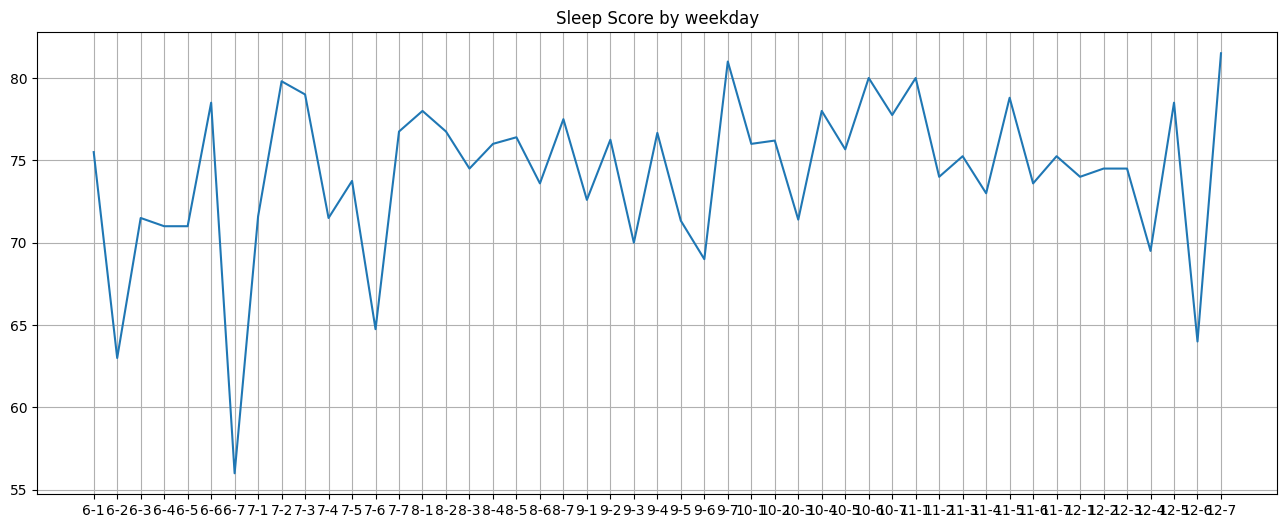

In [ ]:
import matplotlib.pyplot as plt
import polars


plt.figure(figsize=(16,6))
ax = plt.gca()
plt.title("Sleep Score by month+weekday")
plt.grid()
plt.plot(
    sleep_score_by_month_and_weekday.select(
        x=(polars.concat_str(polars.col("group_key.0"), polars.lit("-"), polars.col("group_key.1")))
    ).get_column("x").to_list(),
    sleep_score_by_month_and_weekday.get_column("mean.sleep_score"),
)
plt.show()